# Making predictions on Protegrin-1 mutants 

Here is the procedure used to predicty activity, selectivity and hemolysis in all possible single, double, and triple mutants of protegrin-1. 

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted

import joblib
from sklearn.decomposition import PCA
from sklearn import metrics

pd.set_option('display.max_columns', 100)

%matplotlib inline

In [31]:
# load PCA weights and models for activity prediction
model_mic = joblib.load('models/model_v02_GNB15_esm2_15B_activity_classification.pkl')
pca_mic = joblib.load('models/weights_pca15_v02_esm2_15B_activity.pkl') # mic

# load PCA weights and models for selectivity prediction
model_sel = joblib.load('models/model_v02_svmR20_esm2_15B_selectivity_regression.pkl')
pca_sel = joblib.load('models/weights_pca20_v02_esm2_15B_selectivity.pkl') # sel

# load PCA weights and models for hemolysis prediction
model_hemo = joblib.load('models/model_v02_Lasso30_esm2_15B_hemolysis_regression.pkl')
pca_hemo = joblib.load('models/weights_pca30_v02_esm2_15B_hemolysis.pkl') # hemo


## Predictions on single mutation Protegrin-1 Variants

In [32]:
# load meta_data with mutations on PG1
meta_data = pd.read_csv('data/protegrin_variants_1mut.csv', index_col=0)
meta_data

,ID,Sequence
0,1mut_0,RGGRLCYCRRRFCVLVGR
1,1mut_1,RMGRLCYCRRRFCVCVGR
2,1mut_2,RGGRLCYCRRRFCVCVFR
3,1mut_3,EGGRLCYCRRRFCVCVGR
4,1mut_4,RGGNLCYCRRRFCVCVGR
...,...,...
338,1mut_338,RGGRLCYSRRRFCVCVGR
339,1mut_339,RGGRLCYCRRKFCVCVGR
340,1mut_340,RGGRLCHCRRRFCVCVGR
341,1mut_341,RGGRLCYCRRDFCVCVGR


In [33]:
######################## Load the embedding ######################
# since those embeddings are too large, I saved them in a separate file

# dir_path = 'data/embedding/esm2_15B_pg1_1mut/'
# embeddings = {}
# for file in os.listdir(dir_path):
#         file_path = str(dir_path) + file 
#         label = file.split('.pt')[0]
#         embeddings[label] = np.array(torch.load(file_path)['mean_representations'][48])


## merge embeddings with metadata
# df = meta_data.merge(pd.DataFrame.from_dict(embeddings, orient='index'), how='inner', left_on='ID', right_index=True)

# df.to_pickle('data/embedding/esm2_15B_pg1_1mut.pkl')
# df

In [34]:
# load embeddings from a pickle file
df = pd.read_pickle('data/embedding/esm2_15B_pg1_1mut.pkl')
df

,ID,Sequence,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,...,5070,5071,5072,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,1mut_0,RGGRLCYCRRRFCVLVGR,0.139956,-0.125581,-0.076405,0.146426,-0.280027,0.177829,-0.103134,0.157826,-0.095869,0.238305,-0.166609,-0.106000,0.197645,0.147172,0.172095,-0.173993,0.049640,-0.142380,0.071343,-0.033491,0.175970,0.044800,-0.230723,0.116288,-0.228306,-0.045376,0.081696,-0.078286,0.017577,0.161617,-0.144766,-0.046883,-0.329819,-0.064292,-0.049258,0.030661,0.182056,-0.066748,0.331273,-0.024626,0.153560,-0.341233,0.098469,0.041766,-0.098336,0.335028,0.060487,0.080803,...,-0.290288,-0.138646,0.337517,-0.036846,-0.145865,0.145739,-0.013954,-0.022534,0.266587,0.210630,-0.026933,0.026307,0.076589,0.187688,0.110229,-0.061802,-0.139272,0.225796,-0.113380,-0.024664,-0.230150,-0.086779,-0.018946,-0.150796,0.282690,0.062186,0.217737,0.001308,-0.076220,0.029293,0.134988,0.126751,-0.051001,-0.078870,-0.066645,-0.088527,-0.066581,-0.284267,-0.055163,0.033041,-0.139801,-0.113517,0.121989,-0.190335,0.056447,-0.192906,0.056169,-0.037111,-0.264767,0.061206
1,1mut_1,RMGRLCYCRRRFCVCVGR,0.130926,0.000480,-0.139269,0.132204,-0.236016,0.171966,-0.085120,0.153231,-0.031941,0.153898,-0.142295,-0.114512,0.133251,0.141893,0.076887,-0.163610,0.135277,-0.086710,0.105006,0.039981,0.171417,-0.014597,-0.170309,0.056443,-0.123541,-0.021217,0.097796,-0.054952,0.091123,0.158605,-0.163539,-0.032665,-0.253657,-0.142816,-0.084620,0.004738,0.186130,-0.062229,0.138385,-0.051106,0.132185,-0.129907,0.131162,0.019662,-0.074399,0.299450,0.103770,0.101100,...,-0.303995,-0.181548,0.189195,-0.035498,-0.048187,0.136608,-0.038978,0.003040,0.180409,0.252026,-0.034072,0.067309,0.028784,0.119834,0.231834,-0.008835,-0.155341,0.164639,-0.088200,-0.141192,-0.107459,-0.126025,-0.100561,-0.043595,0.288866,-0.020607,0.087057,-0.002016,-0.042150,0.094406,0.091099,0.142107,-0.021993,-0.063503,0.044875,0.009611,-0.126196,-0.259387,-0.037057,0.041199,-0.139124,-0.158397,0.033567,-0.222891,0.147657,-0.210249,-0.039008,-0.049254,-0.220128,0.026089
2,1mut_2,RGGRLCYCRRRFCVCVFR,0.122494,0.015151,-0.113578,0.147190,-0.248815,0.153636,-0.082545,0.143023,-0.032666,0.198368,-0.141825,-0.072487,0.164319,0.155215,0.000999,-0.142618,0.028556,-0.091350,0.169577,-0.013866,0.158021,-0.034980,-0.236284,0.121333,-0.169987,0.009360,0.132464,-0.091888,0.103464,0.148294,-0.164126,-0.009009,-0.292603,-0.130214,-0.137328,0.002338,0.152275,-0.041424,0.209629,-0.034807,0.131335,-0.169956,0.116559,0.063441,-0.047805,0.292008,0.127569,0.090374,...,-0.341078,-0.151316,0.166382,-0.083772,-0.031800,0.173639,-0.039404,-0.026641,0.183440,0.283105,-0.058492,0.033385,0.051223,0.157715,0.203213,-0.015537,-0.231012,0.176929,-0.108814,-0.151691,-0.155576,-0.138166,-0.069419,-0.081773,0.287196,-0.045575,0.097953,-0.033838,-0.036365,0.125570,0.049084,0.162091,0.003630,-0.094018,-0.003765,0.019716,-0.172657,-0.253969,-0.060248,0.032126,-0.131952,-0.182381,0.012476,-0.216764,0.082182,-0.167000,0.017850,-0.070759,-0.238455,0.011200
3,1mut_3,EGGRLCYCRRRFCVCVGR,0.137794,-0.026297,-0.100598,0.132454,-0.240978,0.123862,-0.108370,0.163518,-0.074148,0.135701,-0.147309,-0.161241,0.135352,0.173438,0.115235,-0.128381,0.062604,-0.100330,0.103954,0.043673,0.147754,0.030620,-0.217643,0.078211,-0.180088,-0.034668,0.076345,-0.030924,0.068764,0.133319,-0.132511,-0.038674,-0.252596,-0.127496,-0.098959,0.027856,0.196983,-0.067005,0.181675,-0.063434,0.197272,-0.178226,0.124807,0.080779,-0.057945,0.309352,0.085288,0.077937,...,-0.238969,-0.153715,0.178666,-0.043892,-0.123913,0.146099,-0.052013,-0.003793,0.247806,0.245565,-0.039263,0.074070,0.054889,0.122570,0.174041,-0.029537,-0.161622,0.190393,-0.111680,-0.081653,-0.096576,-0.078513,-0.077

## Predicting active variants with AMP MBC <= 8

In [35]:
features = df.iloc[:,2:]
features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,5070,5071,5072,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,0.139956,-0.125581,-0.076405,0.146426,-0.280027,0.177829,-0.103134,0.157826,-0.095869,0.238305,-0.166609,-0.106000,0.197645,0.147172,0.172095,-0.173993,0.049640,-0.142380,0.071343,-0.033491,0.175970,0.044800,-0.230723,0.116288,-0.228306,-0.045376,0.081696,-0.078286,0.017577,0.161617,-0.144766,-0.046883,-0.329819,-0.064292,-0.049258,0.030661,0.182056,-0.066748,0.331273,-0.024626,0.153560,-0.341233,0.098469,0.041766,-0.098336,0.335028,0.060487,0.080803,-0.175508,0.016926,...,-0.290288,-0.138646,0.337517,-0.036846,-0.145865,0.145739,-0.013954,-0.022534,0.266587,0.210630,-0.026933,0.026307,0.076589,0.187688,0.110229,-0.061802,-0.139272,0.225796,-0.113380,-0.024664,-0.230150,-0.086779,-0.018946,-0.150796,0.282690,0.062186,0.217737,0.001308,-0.076220,0.029293,0.134988,0.126751,-0.051001,-0.078870,-0.066645,-0.088527,-0.066581,-0.284267,-0.055163,0.033041,-0.139801,-0.113517,0.121989,-0.190335,0.056447,-0.192906,0.056169,-0.037111,-0.264767,0.061206
1,0.130926,0.000480,-0.139269,0.132204,-0.236016,0.171966,-0.085120,0.153231,-0.031941,0.153898,-0.142295,-0.114512,0.133251,0.141893,0.076887,-0.163610,0.135277,-0.086710,0.105006,0.039981,0.171417,-0.014597,-0.170309,0.056443,-0.123541,-0.021217,0.097796,-0.054952,0.091123,0.158605,-0.163539,-0.032665,-0.253657,-0.142816,-0.084620,0.004738,0.186130,-0.062229,0.138385,-0.051106,0.132185,-0.129907,0.131162,0.019662,-0.074399,0.299450,0.103770,0.101100,-0.090511,0.077786,...,-0.303995,-0.181548,0.189195,-0.035498,-0.048187,0.136608,-0.038978,0.003040,0.180409,0.252026,-0.034072,0.067309,0.028784,0.119834,0.231834,-0.008835,-0.155341,0.164639,-0.088200,-0.141192,-0.107459,-0.126025,-0.100561,-0.043595,0.288866,-0.020607,0.087057,-0.002016,-0.042150,0.094406,0.091099,0.142107,-0.021993,-0.063503,0.044875,0.009611,-0.126196,-0.259387,-0.037057,0.041199,-0.139124,-0.158397,0.033567,-0.222891,0.147657,-0.210249,-0.039008,-0.049254,-0.220128,0.026089
2,0.122494,0.015151,-0.113578,0.147190,-0.248815,0.153636,-0.082545,0.143023,-0.032666,0.198368,-0.141825,-0.072487,0.164319,0.155215,0.000999,-0.142618,0.028556,-0.091350,0.169577,-0.013866,0.158021,-0.034980,-0.236284,0.121333,-0.169987,0.009360,0.132464,-0.091888,0.103464,0.148294,-0.164126,-0.009009,-0.292603,-0.130214,-0.137328,0.002338,0.152275,-0.041424,0.209629,-0.034807,0.131335,-0.169956,0.116559,0.063441,-0.047805,0.292008,0.127569,0.090374,-0.093007,-0.003598,...,-0.341078,-0.151316,0.166382,-0.083772,-0.031800,0.173639,-0.039404,-0.026641,0.183440,0.283105,-0.058492,0.033385,0.051223,0.157715,0.203213,-0.015537,-0.231012,0.176929,-0.108814,-0.151691,-0.155576,-0.138166,-0.069419,-0.081773,0.287196,-0.045575,0.097953,-0.033838,-0.036365,0.125570,0.049084,0.162091,0.003630,-0.094018,-0.003765,0.019716,-0.172657,-0.253969,-0.060248,0.032126,-0.131952,-0.182381,0.012476,-0.216764,0.082182,-0.167000,0.017850,-0.070759,-0.238455,0.011200
3,0.137794,-0.026297,-0.100598,0.132454,-0.240978,0.123862,-0.108370,0.163518,-0.074148,0.135701,-0.147309,-0.161241,0.135352,0.173438,0.115235,-0.128381,0.062604,-0.100330,0.103954,0.043673,0.147754,0.030620,-0.217643,0.078211,-0.180088,-0.034668,0.076345,-0.030924,0.068764,0.133319,-0.132511,-0.038674,-0.252596,-0.127496,-0.098959,0.027856,0.196983,-0.067005,0.181675,-0.063434,0.197272,-0.178226,0.124807,0.080779,-0.057945,0.309352,0.085288,0.077937,-0.118641,0.097144,...,-0.238969,-0.153715,0.178666,-0.043892,-0.123913,0.146099,-0.052013,-0.003793,0.247806,0.245565,-0.039263,0.074070,0.054889,0.122570,0.174041,-0.029537,-0.161622,0.190393,-0.111680,-0.081653,-0.096576,-0.078513,-0.077252,-0.082461,0.261394,0.016504,0

### Prediction Activity 

In [36]:
# creates a df to save probabilities
res_mic = df.iloc[:,0:1].copy()

# calculates the probability of being active
X = pca_mic.transform(features)
prob= model_mic.predict_proba(X)
prob= [(x[1]*100).round(2) for x in prob]

res_mic['MIC_8_prob']= prob

#number of peptides with probability == 100%
print(f"{res_mic.query('MIC_8_prob > 90').shape[0]} peptides with probability == 90% to be active")

60 peptides with probability == 90% to be active


### Predicting selectivity score

In [37]:
# creates a df to selectivity score
res_sel = df.iloc[:,0:1].copy()

# calculates the the selectivity score
X = pca_sel.transform(features)
prob= model_sel.predict(X)
res_sel['selectivity_pred']= prob.round(2) 

#number of peptides with selectivity score < 0.8
print(f"{res_sel.query('selectivity_pred < 0.5').shape[0]} peptides with selectivity score < 0.5")

0 peptides with selectivity score < 0.5


### Prediction of Hemolysis % to protegrin-1 variants

In [38]:
# creates a df to save hemolysis score
res_hemo = df.iloc[:,0:1].copy()

# calculates the the hemolysis score
X = pca_hemo.transform(features)
pred= model_hemo.predict(X)
res_hemo['hemolysis_pred']= pred.round(2)

#number of peptides with hemolysis score < 1
print(f"{res_hemo.query('hemolysis_pred <= 2').shape[0]} peptides with predicted hemolysis% < 2%")

5 peptides with predicted hemolysis% < 2%


## Results of single mutant

In [39]:
results = res_mic.merge(res_sel[['ID', 'selectivity_pred']], how='inner', left_on='ID', right_on='ID')
results = results.merge(res_hemo[['ID', 'hemolysis_pred']], how='inner', left_on='ID', right_on='ID')
results = meta_data.merge(results, how='inner', left_on='ID', right_on='ID')
results

,ID,Sequence,MIC_8_prob,selectivity_pred,hemolysis_pred
0,1mut_0,RGGRLCYCRRRFCVLVGR,89.74,1.62,8.070000
1,1mut_1,RMGRLCYCRRRFCVCVGR,92.41,2.38,34.259998
2,1mut_2,RGGRLCYCRRRFCVCVFR,82.40,2.91,38.820000
3,1mut_3,EGGRLCYCRRRFCVCVGR,88.35,2.30,29.030001
4,1mut_4,RGGNLCYCRRRFCVCVGR,90.86,2.23,28.600000
...,...,...,...,...,...
338,1mut_338,RGGRLCYSRRRFCVCVGR,80.17,2.44,18.200001
339,1mut_339,RGGRLCYCRRKFCVCVGR,69.70,2.26,29.580000
340,1mut_340,RGGRLCHCRRRFCVCVGR,77.40,1.86,19.410000
341,1mut_341,RGGRLCYCRRDFCVCVGR,58.46,2.21,25.959999


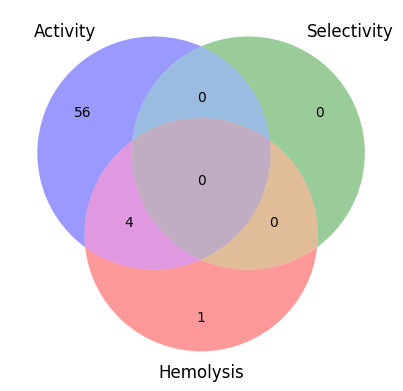

In [40]:
# Define the sets as lists of elements
set1 = set(results.query('MIC_8_prob > 90')['ID'].values)
set2 = set(results.query('selectivity_pred < 1')['ID'].values)
set3 = set(results.query('hemolysis_pred <= 2')['ID'].values)

# Create the Venn diagram
venn3_unweighted([set1, set2, set3], set_labels=('Activity', 'Selectivity', 'Hemolysis'), set_colors=('b', 'g', 'r'))
#plt.savefig('MIC_HEMO_SEL_1mut_venn3_predictions_v02.png')
plt.show()

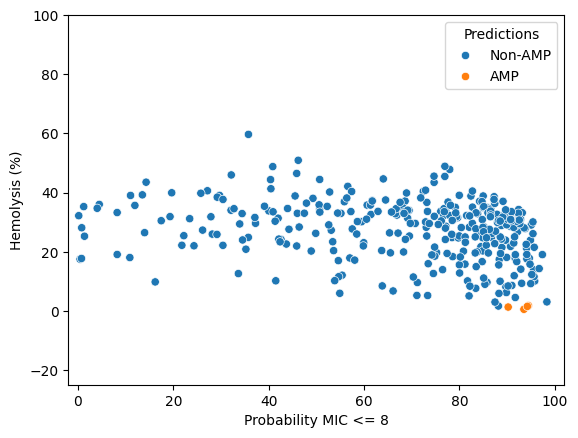

In [41]:
color1 = results.apply(lambda x: 'AMP' if x['MIC_8_prob'] > 90 and x['hemolysis_pred'] <=2 else 'Non-AMP', axis=1).values

sns.scatterplot(data=results, x='MIC_8_prob', y='hemolysis_pred', hue=color1)
plt.xlabel('Probability MIC <= 8')
plt.ylabel('Hemolysis (%)')
plt.legend(loc='upper center')
plt.legend(title= "Predictions")
plt.ylim(-25,100)
plt.xlim(-2,102)
plt.show()

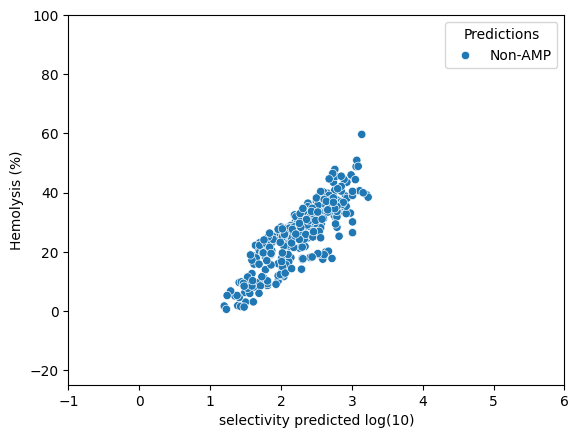

In [42]:
color2 = results.apply(lambda x: 'AMP' if x['selectivity_pred'] < 0.5 and x['hemolysis_pred'] <=2 else 'Non-AMP', axis=1).values

sns.scatterplot(data=results, x='selectivity_pred', y='hemolysis_pred', hue=color2)
plt.ylabel('Hemolysis (%)')
plt.xlabel('selectivity predicted log(10)')
plt.legend(loc='upper right')
plt.ylim(-25,100)
plt.xlim(-1,6)
plt.legend(title= "Predictions")
plt.show()

In [43]:
# saving results
results.to_csv('results/predictions_MIC_SEL_HEMO_models_PG1_1mut_v02.csv')

## Predictions on double mutation Protegrin-1 Variants

In [44]:
# load meta_data with mutations on PG1
meta_data = pd.read_csv('data/protegrin_variants_2mut.csv', index_col=0)
meta_data

,ID,Sequence
0,2mut_0,RGPRLCYCRRRQCVCVGR
1,2mut_1,YGGPLCYCRRRFCVCVGR
2,2mut_2,RKGRLCGCRRRFCVCVGR
3,2mut_3,RGGRLCYCRRWFCVKVGR
4,2mut_4,RGGRLCYCMRRFCVCDGR
...,...,...
55571,2mut_55571,CGGRLCYCRRRWCVCVGR
55572,2mut_55572,RGGRLCYCRRRHDVCVGR
55573,2mut_55573,RGGRMCYCRRRFCVCVAR
55574,2mut_55574,RGGRLCYCRIRFIVCVGR


In [45]:
######################## Load the embedding ######################
# since those embeddings are too large, I saved them in a separate file

# dir_path = '/stor/work/Wilke/luiz/ML_PG1/embeddings/esm2_15B_pg1_2mut/'
# embeddings = {}
# for file in os.listdir(dir_path):
#         file_path = str(dir_path) + file 
#         label = file.split('.pt')[0]
#         embeddings[label] = np.array(torch.load(file_path)['mean_representations'][48])


# # merge embeddings with metadata
# df = meta_data.merge(pd.DataFrame.from_dict(embeddings, orient='index'), how='inner', left_on='ID', right_index=True)

# df.to_pickle('data/embedding/esm2_15B_pg1_2mut.pkl')

In [46]:
# load embeddings from a pickle file
df = pd.read_pickle(f'data/embedding/esm2_15B_pg1_2mut.pkl')
df

,ID,Sequence,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,...,5070,5071,5072,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,2mut_0,RGPRLCYCRRRQCVCVGR,0.030471,-0.036276,-0.111070,0.150194,-0.230985,0.181216,-0.178246,0.158280,-0.044290,0.140545,-0.173849,-0.074231,0.127456,0.139890,0.141800,-0.161217,0.052185,-0.073374,0.231049,0.004841,0.076786,-0.000564,-0.235507,0.093585,-0.094216,-0.030184,0.090808,-0.017730,0.056953,0.168276,-0.138922,-0.055812,-0.238720,-0.121912,-0.131041,0.009613,0.166661,-0.117495,0.190636,-0.058775,0.083950,-0.137385,0.066807,0.088748,-0.054584,0.269736,0.049476,0.108028,...,-0.332250,-0.182212,0.188159,-0.089034,-0.064079,0.156366,-0.090362,-0.010652,0.187834,0.213740,-0.055363,-0.009788,0.014521,0.185780,0.124452,0.013869,-0.185609,0.156731,-0.108033,-0.137903,-0.097508,-0.199132,-0.055758,-0.013001,0.282426,-0.031745,0.175234,-0.038487,0.071631,0.056087,0.094258,0.134074,-0.014872,-0.083226,-0.015783,0.033664,-0.126464,-0.285006,-0.048229,0.061758,-0.191082,-0.151428,0.059017,-0.244604,0.117419,-0.155859,-0.045599,-0.075758,-0.259623,0.045590
1,2mut_1,YGGPLCYCRRRFCVCVGR,0.078283,-0.004239,-0.083609,0.105327,-0.233435,0.161460,-0.106038,0.203431,-0.081741,0.155934,-0.148036,-0.138177,0.127338,0.172699,0.143295,-0.190010,0.101302,-0.077433,0.149300,0.018422,0.155382,0.059158,-0.202118,0.056027,-0.144371,-0.061357,0.085607,-0.040719,0.005678,0.153111,-0.134872,-0.038001,-0.213945,-0.130888,-0.058073,0.013071,0.204674,-0.049626,0.176748,-0.075964,0.177314,-0.164634,0.122157,0.013722,-0.078917,0.326256,0.102039,0.064966,...,-0.208491,-0.181908,0.204974,0.013904,-0.081345,0.084125,-0.008529,-0.013594,0.245070,0.272875,-0.054534,0.077179,0.028892,0.122911,0.150612,-0.056876,-0.118520,0.162811,-0.106010,-0.062028,-0.084144,-0.140908,-0.094160,-0.074398,0.280061,-0.020089,0.090262,0.008972,-0.009543,0.066797,0.110991,0.168301,-0.014092,-0.092231,0.006551,0.018966,-0.110038,-0.285004,-0.044679,0.036731,-0.182719,-0.162484,0.037435,-0.229143,0.173071,-0.190800,-0.026766,-0.103359,-0.266636,0.025352
2,2mut_2,RKGRLCGCRRRFCVCVGR,0.085428,-0.057224,-0.048115,0.131888,-0.233556,0.146629,-0.058954,0.145036,-0.012269,0.208369,-0.116377,-0.063401,0.179298,0.176179,0.089100,-0.128998,0.192588,-0.062569,0.056391,-0.061444,0.136877,0.051762,-0.240653,0.131735,-0.155009,-0.012141,0.110780,-0.081294,0.068365,0.167697,-0.143250,0.005252,-0.351505,-0.103353,-0.154235,0.003228,0.185293,-0.056369,0.242288,-0.047226,0.159304,-0.101366,0.098639,0.058434,-0.045043,0.278100,0.043613,0.063437,...,-0.328105,-0.162223,0.256969,-0.061340,-0.029240,0.072979,-0.043325,-0.013580,0.229346,0.264277,-0.033285,0.013914,-0.017617,0.160241,0.176237,-0.087623,-0.177227,0.208036,-0.145973,0.000206,-0.188131,-0.057958,-0.108080,-0.064826,0.241150,0.070687,0.167148,-0.012571,-0.008496,0.036840,0.092076,0.183831,-0.038787,-0.071339,-0.011860,-0.058060,-0.045512,-0.228114,-0.049612,-0.007920,-0.166855,-0.198541,0.027955,-0.190623,0.077585,-0.172339,0.024809,-0.092293,-0.187360,0.020935
3,2mut_3,RGGRLCYCRRWFCVKVGR,0.057880,-0.050223,-0.124206,0.076189,-0.272554,0.140542,-0.079627,0.214544,-0.021029,0.190860,-0.159807,-0.098083,0.199157,0.179230,0.109095,-0.135120,0.113276,-0.068056,0.066501,0.022015,0.165217,0.009979,-0.291171,0.147817,-0.147829,-0.041164,0.068331,-0.102698,-0.041732,0.109131,-0.132808,-0.042759,-0.286052,-0.113242,-0.090135,-0.022518,0.168574,-0.058750,0.236315,-0.028953,0.159713,-0.287824,0.157747,0.060543,-0.057961,0.306598,0.056881,0.039657,...,-0.307967,-0.126027,0.237130,-0.060796,-0.106810,0.076391,-0.032235,0.007105,0.312369,0.172563,-0.045592,0.099534,0.065470,0.134455,0.143874,0.002906,-0.142259,0.190600,-0.021462,-0.018197,-0.208055,-0.071023,-0.0

### Prediction of active variants (MBC <= 8)

In [47]:
features = df.iloc[:,2:]
features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,5070,5071,5072,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,0.030471,-0.036276,-0.111070,0.150194,-0.230985,0.181216,-0.178246,0.158280,-0.044290,0.140545,-0.173849,-0.074231,0.127456,0.139890,0.141800,-0.161217,0.052185,-0.073374,0.231049,0.004841,0.076786,-0.000564,-0.235507,0.093585,-0.094216,-0.030184,0.090808,-0.017730,0.056953,0.168276,-0.138922,-0.055812,-0.238720,-0.121912,-0.131041,0.009613,0.166661,-0.117495,0.190636,-0.058775,0.083950,-0.137385,0.066807,0.088748,-0.054584,0.269736,0.049476,0.108028,-0.137416,-0.012448,...,-0.332250,-0.182212,0.188159,-0.089034,-0.064079,0.156366,-0.090362,-0.010652,0.187834,0.213740,-0.055363,-0.009788,0.014521,0.185780,0.124452,0.013869,-0.185609,0.156731,-0.108033,-0.137903,-0.097508,-0.199132,-0.055758,-0.013001,0.282426,-0.031745,0.175234,-0.038487,0.071631,0.056087,0.094258,0.134074,-0.014872,-0.083226,-0.015783,0.033664,-0.126464,-0.285006,-0.048229,0.061758,-0.191082,-0.151428,0.059017,-0.244604,0.117419,-0.155859,-0.045599,-0.075758,-0.259623,0.045590
1,0.078283,-0.004239,-0.083609,0.105327,-0.233435,0.161460,-0.106038,0.203431,-0.081741,0.155934,-0.148036,-0.138177,0.127338,0.172699,0.143295,-0.190010,0.101302,-0.077433,0.149300,0.018422,0.155382,0.059158,-0.202118,0.056027,-0.144371,-0.061357,0.085607,-0.040719,0.005678,0.153111,-0.134872,-0.038001,-0.213945,-0.130888,-0.058073,0.013071,0.204674,-0.049626,0.176748,-0.075964,0.177314,-0.164634,0.122157,0.013722,-0.078917,0.326256,0.102039,0.064966,-0.110125,0.141647,...,-0.208491,-0.181908,0.204974,0.013904,-0.081345,0.084125,-0.008529,-0.013594,0.245070,0.272875,-0.054534,0.077179,0.028892,0.122911,0.150612,-0.056876,-0.118520,0.162811,-0.106010,-0.062028,-0.084144,-0.140908,-0.094160,-0.074398,0.280061,-0.020089,0.090262,0.008972,-0.009543,0.066797,0.110991,0.168301,-0.014092,-0.092231,0.006551,0.018966,-0.110038,-0.285004,-0.044679,0.036731,-0.182719,-0.162484,0.037435,-0.229143,0.173071,-0.190800,-0.026766,-0.103359,-0.266636,0.025352
2,0.085428,-0.057224,-0.048115,0.131888,-0.233556,0.146629,-0.058954,0.145036,-0.012269,0.208369,-0.116377,-0.063401,0.179298,0.176179,0.089100,-0.128998,0.192588,-0.062569,0.056391,-0.061444,0.136877,0.051762,-0.240653,0.131735,-0.155009,-0.012141,0.110780,-0.081294,0.068365,0.167697,-0.143250,0.005252,-0.351505,-0.103353,-0.154235,0.003228,0.185293,-0.056369,0.242288,-0.047226,0.159304,-0.101366,0.098639,0.058434,-0.045043,0.278100,0.043613,0.063437,-0.112073,0.060039,...,-0.328105,-0.162223,0.256969,-0.061340,-0.029240,0.072979,-0.043325,-0.013580,0.229346,0.264277,-0.033285,0.013914,-0.017617,0.160241,0.176237,-0.087623,-0.177227,0.208036,-0.145973,0.000206,-0.188131,-0.057958,-0.108080,-0.064826,0.241150,0.070687,0.167148,-0.012571,-0.008496,0.036840,0.092076,0.183831,-0.038787,-0.071339,-0.011860,-0.058060,-0.045512,-0.228114,-0.049612,-0.007920,-0.166855,-0.198541,0.027955,-0.190623,0.077585,-0.172339,0.024809,-0.092293,-0.187360,0.020935
3,0.057880,-0.050223,-0.124206,0.076189,-0.272554,0.140542,-0.079627,0.214544,-0.021029,0.190860,-0.159807,-0.098083,0.199157,0.179230,0.109095,-0.135120,0.113276,-0.068056,0.066501,0.022015,0.165217,0.009979,-0.291171,0.147817,-0.147829,-0.041164,0.068331,-0.102698,-0.041732,0.109131,-0.132808,-0.042759,-0.286052,-0.113242,-0.090135,-0.022518,0.168574,-0.058750,0.236315,-0.028953,0.159713,-0.287824,0.157747,0.060543,-0.057961,0.306598,0.056881,0.039657,-0.070077,-0.037522,...,-0.307967,-0.126027,0.237130,-0.060796,-0.106810,0.076391,-0.032235,0.007105,0.312369,0.172563,-0.045592,0.099534,0.065470,0.134455,0.143874,0.002906,-0.142259,0.190600,-0.021462,-0.018197,-0.208055,-0.071023,-0.081870,-0.171144,0.213066,-0.0094

In [48]:
# creates a df to save probabilities
res_mic = df.iloc[:,0:1].copy()

# calculates the probability of being active
X = pca_mic.transform(features)
prob= model_mic.predict_proba(X)
prob= [(x[1]*100).round(2) for x in prob]

res_mic['MIC_8_prob']= prob

#number of peptides with probability == 100%
print(f"{res_mic.query('MIC_8_prob > 90').shape[0]} peptides with probability == 90% to be active")

4950 peptides with probability == 90% to be active


### Predicting selectivity score

In [49]:
# creates a df to selectivity score
res_sel = df.iloc[:,0:1].copy()

# calculates the the selectivity score
X = pca_sel.transform(features)
prob= model_sel.predict(X)
res_sel['selectivity_pred']= prob.round(2) 

#number of peptides with selectivity score < 0.8
print(f"{res_sel.query('selectivity_pred < 0.5').shape[0]} peptides with selectivity score < 0.5")

0 peptides with selectivity score < 0.5


### Prediction nom Hemolitic variants (hemolysis% < 2%)

In [50]:
# creates a df to save hemolysis score
res_hemo = df.iloc[:,0:1].copy()

# calculates the the hemolysis score
X = pca_hemo.transform(features)
pred= model_hemo.predict(X)
res_hemo['hemolysis_pred']= pred.round(2)

#number of peptides with hemolysis score < 1
print(f"{res_hemo.query('hemolysis_pred <= 2').shape[0]} peptides with predicted hemolysis% < 2%")

2290 peptides with predicted hemolysis% < 2%


### Results of double mutants

In [51]:
results = res_mic.merge(res_sel[['ID', 'selectivity_pred']], how='inner', left_on='ID', right_on='ID')
results = results.merge(res_hemo[['ID', 'hemolysis_pred']], how='inner', left_on='ID', right_on='ID')
results = meta_data.merge(results, how='inner', left_on='ID', right_on='ID')
results

,ID,Sequence,MIC_8_prob,selectivity_pred,hemolysis_pred
0,2mut_0,RGPRLCYCRRRQCVCVGR,50.84,1.97,23.709999
1,2mut_1,YGGPLCYCRRRFCVCVGR,74.58,2.55,31.430000
2,2mut_2,RKGRLCGCRRRFCVCVGR,88.54,1.87,15.300000
3,2mut_3,RGGRLCYCRRWFCVKVGR,0.82,1.94,24.330000
4,2mut_4,RGGRLCYCMRRFCVCDGR,52.21,1.92,19.900000
...,...,...,...,...,...
55571,2mut_55571,CGGRLCYCRRRWCVCVGR,12.75,2.70,36.779999
55572,2mut_55572,RGGRLCYCRRRHDVCVGR,7.25,1.08,-1.030000
55573,2mut_55573,RGGRMCYCRRRFCVCVAR,93.07,2.18,27.690001
55574,2mut_55574,RGGRLCYCRIRFIVCVGR,30.36,2.74,14.570000


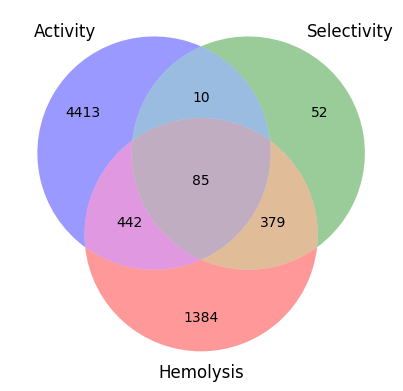

In [52]:
# Define the sets as lists of elements
set1 = set(results.query('MIC_8_prob > 90')['ID'].values)
set2 = set(results.query('selectivity_pred < 1')['ID'].values)
set3 = set(results.query('hemolysis_pred <= 2')['ID'].values)

# Create the Venn diagram
venn3_unweighted([set1, set2, set3], set_labels=('Activity', 'Selectivity', 'Hemolysis'), set_colors=('b', 'g', 'r'))
#plt.savefig('MIC_HEMO_SEL_2mut_venn3_predictions_v02.png')
plt.show()

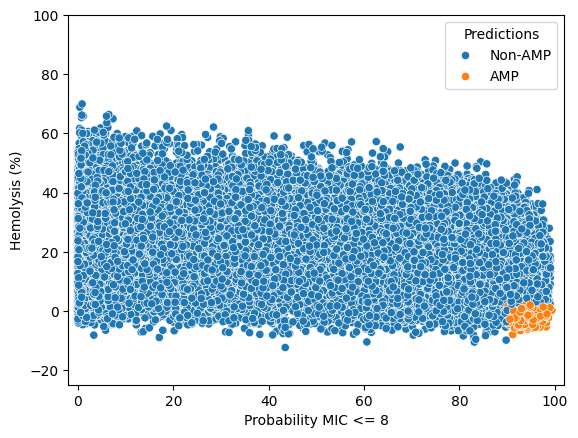

In [53]:
color1 = results.apply(lambda x: 'AMP' if x['MIC_8_prob'] > 90 and x['hemolysis_pred'] <=2 else 'Non-AMP', axis=1).values

sns.scatterplot(data=results, x='MIC_8_prob', y='hemolysis_pred', hue=color1)
plt.xlabel('Probability MIC <= 8')
plt.ylabel('Hemolysis (%)')
plt.legend(loc='upper center')
plt.legend(title= "Predictions")
plt.ylim(-25,100)
plt.xlim(-2,102)
plt.show()

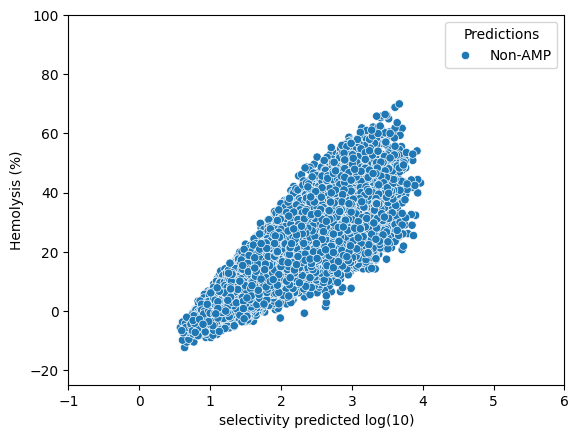

In [54]:
color2 = results.apply(lambda x: 'AMP' if x['selectivity_pred'] < 0.5 and x['hemolysis_pred'] <=2 else 'Non-AMP', axis=1).values

sns.scatterplot(data=results, x='selectivity_pred', y='hemolysis_pred', hue=color2)
plt.ylabel('Hemolysis (%)')
plt.xlabel('selectivity predicted log(10)')
plt.legend(loc='upper right')
plt.ylim(-25,100)
plt.xlim(-1,6)
plt.legend(title= "Predictions")
plt.show()

In [55]:
# saving results
results.to_csv('results/predictions_MIC_SEL_HEMO_models_PG1_2mut_v02.csv')

## Predictions on triple mutant Protegrin-1 Variants

In [23]:
### Those functions will be used to predict the triple mutants in a loop
def run_mic(features):    
    # creates a df to save probabilities
    res_mic = pd.DataFrame()

    # calculates the probability of being active
    X = pca_mic.transform(features)
    prob= model_mic.predict_proba(X)
    prob= [(x[1]*100).round(2) for x in prob]
    
    res_mic['ID']=features.index
    res_mic['MIC_8_prob']=prob

    return res_mic

In [24]:
### Predicting selectivity score
def run_sel(features):
    # creates a df to selectivity score
    res_sel = pd.DataFrame()

    # calculates the the selectivity score
    X = pca_sel.transform(features)
    prob= model_sel.predict(X)

    res_sel['ID']=features.index
    res_sel['selectivity_pred']= prob.round(2) 

    return res_sel

In [25]:
### Prediction nom Hemolitic variants (hemolysis% < 2%)
def run_hemo(features):
    # creates a df to save hemolysis score
    res_hemo = pd.DataFrame()

    # calculates the the hemolysis score
    X = pca_hemo.transform(features)
    pred= model_hemo.predict(X)

    res_hemo['ID']=features.index
    res_hemo['hemolysis_pred']= pred.round(2)

    return res_hemo

### Preprocess the embedding from a tensor file to a lighter pickle file

In [30]:
# import multiprocessing

# # this was required to load the embeddings with multiple CPUs due the large file sizes
# for i in range(1,7):
#     '''this loop will load the embeddings with multiple CPUs and save them in a pickle file'''

#     # Set the directory containing the Torch files
#     data_dir = f'data/embedding/esm2_15B_pg1_3mut/esm2_15B_pg1_3mut_{i}mil/'

#     # Define the function to load a Torch file
#     def load_torch_file(filename):
#         filepath = os.path.join(data_dir, filename)
#         label = filename.split('.pt')[0]
#         embeddings = {}
#         embeddings[label] = np.array(torch.load(filepath)['mean_representations'][48])
#         return embeddings

#     # Get a list of all the Torch files in the directory
#     file_list = os.listdir(data_dir)

#     # Define the number of processes to use
#     num_processes = 50

#     # Create a multiprocessing pool with the number of processes defined above
#     pool = multiprocessing.Pool(processes=num_processes)

#     # Use the pool to load all the Torch files in parallel
#     results = pool.map(load_torch_file, file_list)

#     # Close the pool
#     pool.close()

#     # Concatenate the results into a single list
#     all_data = {k: v for d in results for k, v in d.items()}

#     # Convert the dictionary to a NumPy array
#     arr = np.array(list(all_data.values()))

#     # Set the keys as the index
#     index = list(all_data.keys())

#     # Create a DataFrame from the array
#     df = pd.DataFrame(arr, index=index)

#     # Print the DataFrame and renamed it
#     df.to_pickle(f'data/embedding/esm2_15B_pg1_3mut_{i}mil.pkl')

### Loaning the pre processced embedding from a pickle file and run prediction on each splited file
I have to split the files in 6 parts due its huge size

In [26]:
# read the CSV files and concatenate them row-wise
predictions = pd.DataFrame()

for i in range(1, 7):
    file_path = f'data/embedding/esm2_15B_pg1_3mut_{i}mil.pkl'
    features = pd.read_pickle(file_path)
    print(f'Processing file esm2_15B_pg1_3mut_{i}mil, size: {features.shape}')
    
    res_mic = run_mic(features)
    res_sel = run_sel(features)
    res_hemo = run_hemo(features)
    
    res = res_mic.merge(res_sel[['ID', 'selectivity_pred']], how='inner', left_on='ID', right_on='ID')
    res = res.merge(res_hemo[['ID', 'hemolysis_pred']], how='inner', left_on='ID', right_on='ID')

    predictions = pd.concat([predictions, res], axis=0).reset_index(drop=True)
    print(f'Prediction size: {predictions.shape[0]}')

predictions

Processing file esm2_15B_pg1_3mut_1mil, size: (1000000, 5120)
Prediction size: 1000000
Processing file esm2_15B_pg1_3mut_2mil, size: (1000000, 5120)
Prediction size: 2000000
Processing file esm2_15B_pg1_3mut_3mil, size: (1000000, 5120)
Prediction size: 3000000
Processing file esm2_15B_pg1_3mut_4mil, size: (1000000, 5120)
Prediction size: 4000000
Processing file esm2_15B_pg1_3mut_5mil, size: (1000000, 5120)
Prediction size: 5000000
Processing file esm2_15B_pg1_3mut_6mil, size: (652520, 5120)
Prediction size: 5652520


,ID,MIC_8_prob,selectivity_pred,hemolysis_pred
0,PG1_3mut_602975,32.69,1.87,12.090000
1,PG1_3mut_185031,73.40,2.30,7.360000
2,PG1_3mut_332050,1.96,1.30,1.230000
3,PG1_3mut_938612,40.69,2.89,29.830000
4,PG1_3mut_894404,3.88,1.87,17.580000
...,...,...,...,...
5652515,PG1_3mut_5154857,3.31,2.02,16.570000
5652516,PG1_3mut_5261581,45.79,2.17,13.220000
5652517,PG1_3mut_5406149,52.93,2.65,17.639999
5652518,PG1_3mut_5061684,79.62,1.94,19.600000


## Load meta data and merge with results

In [27]:
meta_data = pd.read_csv('data/protegrin_variants_3mut.csv', index_col=0)
results = meta_data.merge(predictions, how='inner', left_on='ID', right_on='ID')
results

,ID,Sequence,MIC_8_prob,selectivity_pred,hemolysis_pred
0,PG1_3mut_0,HGGRLCYCRRRFCVCQTR,41.88,1.75,20.580000
1,PG1_3mut_1,RGGQLCYVRRRFCVAVGR,69.43,1.41,2.530000
2,PG1_3mut_2,RCYRLCRCRRRFCVCVGR,16.65,2.38,32.959999
3,PG1_3mut_3,RGSRLCYCRRRFCMCVIR,49.37,2.43,33.820000
4,PG1_3mut_4,RGGRRCYCWRAFCVCVGR,72.45,2.72,40.619999
...,...,...,...,...,...
5652515,PG1_3mut_5652515,RGIRLCYCERRSCVCVGR,48.97,2.06,14.600000
5652516,PG1_3mut_5652516,RGGRLCACRRLFCVCVGV,0.00,3.17,15.340000
5652517,PG1_3mut_5652517,RGGDLCLCLRRFCVCVGR,0.01,2.97,16.530001
5652518,PG1_3mut_5652518,FGGRLCYCRRRFCQGVGR,18.83,1.39,5.390000


In [27]:
# saving results
results.to_csv('results/predictions_MIC_SEL_HEMO_models_PG1_3mut_v02.csv')
#results = pd.read_csv('results/predictions_MIC_SEL_HEMO_models_PG1_3mut_v02.csv')

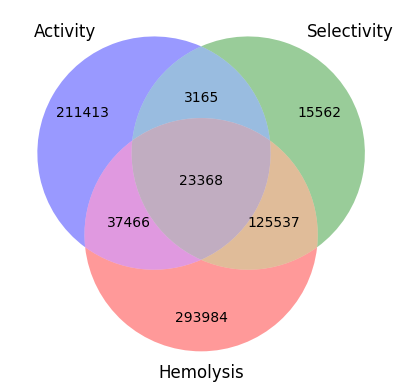

In [28]:
# Define the sets as lists of elements
set1 = set(results.query('MIC_8_prob > 90')['ID'].values)
set2 = set(results.query('selectivity_pred < 1')['ID'].values)
set3 = set(results.query('hemolysis_pred <= 2')['ID'].values)

# Create the Venn diagram
venn3_unweighted([set1, set2, set3], set_labels=('Activity', 'Selectivity', 'Hemolysis'), set_colors=('b', 'g', 'r'))
plt.show()

# Merge predictions and visualization

In [56]:
# loop trhrough the 3 predictions files and concatenate them
files = []
for i in range(1, 4):
    file = pd.read_csv(f'results/predictions_MIC_SEL_HEMO_models_PG1_{i}mut_v02.csv', index_col=0)
    files.append(file)

data = pd.concat(files, axis=0)
data

,ID,Sequence,MIC_8_prob,selectivity_pred,hemolysis_pred
0,1mut_0,RGGRLCYCRRRFCVLVGR,89.74,1.62,8.07
1,1mut_1,RMGRLCYCRRRFCVCVGR,92.41,2.38,34.26
2,1mut_2,RGGRLCYCRRRFCVCVFR,82.40,2.91,38.82
3,1mut_3,EGGRLCYCRRRFCVCVGR,88.35,2.30,29.03
4,1mut_4,RGGNLCYCRRRFCVCVGR,90.86,2.23,28.60
...,...,...,...,...,...
5652515,PG1_3mut_5652515,RGIRLCYCERRSCVCVGR,48.97,2.06,14.60
5652516,PG1_3mut_5652516,RGGRLCACRRLFCVCVGV,0.00,3.17,15.34
5652517,PG1_3mut_5652517,RGGDLCLCLRRFCVCVGR,0.01,2.97,16.53
5652518,PG1_3mut_5652518,FGGRLCYCRRRFCQGVGR,18.83,1.39,5.39


In [2]:
## SAVE the file compressed
#data.to_csv('results/predictions_MIC_SEL_HEMO_models_PG1_1-3mut_v02.csv.gz', index=False, compression='gzip')

## LOAD the file
data = pd.read_csv('results/predictions_MIC_SEL_HEMO_models_PG1_1-3mut_v02.csv.gz', compression='gzip')
data

,ID,Sequence,MIC_8_prob,selectivity_pred,hemolysis_pred
0,1mut_0,RGGRLCYCRRRFCVLVGR,89.74,1.62,8.07
1,1mut_1,RMGRLCYCRRRFCVCVGR,92.41,2.38,34.26
2,1mut_2,RGGRLCYCRRRFCVCVFR,82.40,2.91,38.82
3,1mut_3,EGGRLCYCRRRFCVCVGR,88.35,2.30,29.03
4,1mut_4,RGGNLCYCRRRFCVCVGR,90.86,2.23,28.60
...,...,...,...,...,...
5708434,PG1_3mut_5652515,RGIRLCYCERRSCVCVGR,48.97,2.06,14.60
5708435,PG1_3mut_5652516,RGGRLCACRRLFCVCVGV,0.00,3.17,15.34
5708436,PG1_3mut_5652517,RGGDLCLCLRRFCVCVGR,0.01,2.97,16.53
5708437,PG1_3mut_5652518,FGGRLCYCRRRFCQGVGR,18.83,1.39,5.39


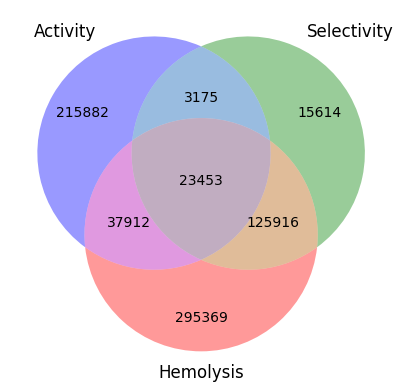

In [3]:
#Define the sets as lists of elements
set1 = set(data.query('MIC_8_prob > 90')['ID'].values)
set2 = set(data.query('selectivity_pred < 1')['ID'].values)
set3 = set(data.query('hemolysis_pred <= 2')['ID'].values)


# Create the Venn diagram
venn3_unweighted([set1, set2, set3], set_labels=('Activity', 'Selectivity', 'Hemolysis'), set_colors=('b', 'g', 'r'))
#plt.savefig('results/MIC_HEMO_SEL_all_mutations_venn3_predictions_most_active_v02.png')
plt.show()

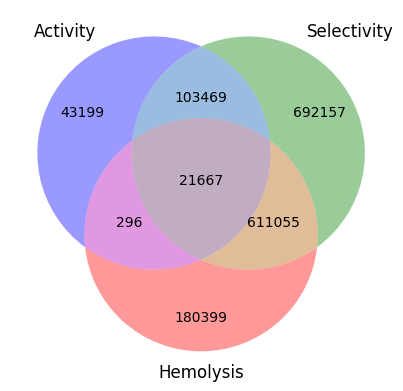

In [4]:
#Define the sets as lists of elements
set1 = set(data.query('MIC_8_prob ==0')['ID'].values)
set2 = set(data.query('selectivity_pred > 2.5')['ID'].values)
set3 = set(data.query('hemolysis_pred > 30')['ID'].values)


# Create the Venn diagram
venn3_unweighted([set1, set2, set3], set_labels=('Activity', 'Selectivity', 'Hemolysis'), set_colors=('b', 'g', 'r'))
#plt.savefig('results/MIC_HEMO_SEL_all_mutations_venn3_predictions_least_active_v02.png')
plt.show()

# AA Frequency Change 

In [5]:
### Bacterial and Mammalian specific peptides
bac = data.query('MIC_8_prob > 90 and selectivity_pred < 0.5 and hemolysis_pred <=2').copy()

### Mamalian specific peptides
mamm = data.query('MIC_8_prob == 0 and selectivity_pred > 2.35 and hemolysis_pred > 50').copy()

### Most selective
most_sel = data.query('selectivity_pred < 0.5').copy()

### Least hemolitic
least_hemo = data.query('hemolysis_pred <= 2').copy()

### Most active
most_act = data.query('MIC_8_prob >90').copy()


print(f"Number of Bacterial specific peptides: {bac.shape[0]}")
print(f"Number of Mamalian specific peptides: {mamm.shape[0]}")
print(f"Number of Most selective peptides: {most_sel.shape[0]}")
print(f"Number of Least hemolitic peptides: {least_hemo.shape[0]}")
print(f"Number of Most active peptides: {most_act.shape[0]}")

Number of Bacterial specific peptides: 661
Number of Mamalian specific peptides: 1062
Number of Most selective peptides: 4117
Number of Least hemolitic peptides: 482650
Number of Most active peptides: 280422


### AA frequency change in most active peptides

In [6]:
# def to find the differences between the residues
idx = "RRRRICYCPLRFYVCVGR"

def diff_func(idxx):
    pg1 = "RGGRLCYCRRRFCVCVGR"
    idx = idxx
    diff = []
    for i in range(0, len(pg1)):
        aa = idx[i]
        pg_aa = pg1[i]
        
        if pg_aa == aa:
            diff.append("-")
        else:
            diff.append(aa)
    diff_seq = "".join(diff)
    return diff_seq


diff_func(idx)

'-RR-I---PL--Y-----'

# HeatMaps

## Most Active Peptides

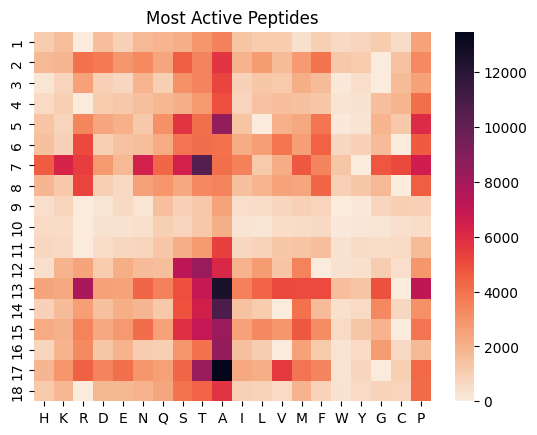

In [7]:
# prepare the matrix to plot the heatmap
most_act["difference_in_seq"] = [diff_func(x) for x in most_act["Sequence"]]
diff = most_act["difference_in_seq"].str.split("", n= -1, expand = True)
most_act = most_act.merge(diff, left_index=True, right_index=True)


# charged->polar->aliphatic->aromatic->other
aa_list = ['H', 'K', 'R', 'D', 'E', 'N', 'Q', 'S', 'T', 'A', 'I', 'L', 'V', 'M', 'F', 'W', 'Y','G', 'C', 'P']

#aa_list = ['H', 'K', 'R', 'D', 'E', 'A', 'I', 'L', 'V', 'M', 'F', 'W', 'Y', 'N', 'Q', 'S', 'T', 'G', 'C', 'P']
mtx = pd.DataFrame(0, index=aa_list, columns=np.arange(1, 19))

# fill the matix with the count of each amino acid in each position
for i in range(1, 19):
    pos_count = most_act[i].value_counts().to_dict()

    for k,v in pos_count.items():
        if k != '-':
            mtx.loc[k,i] = v

# plot the heatmap
plt.title("Most Active Peptides")
sns.heatmap(mtx.T, cmap="rocket_r")
#plt.savefig('results/changes_heatmap_predictions_most_active_v02.png', dpi=1200)
plt.show()

## Least Hemolitic Peptides

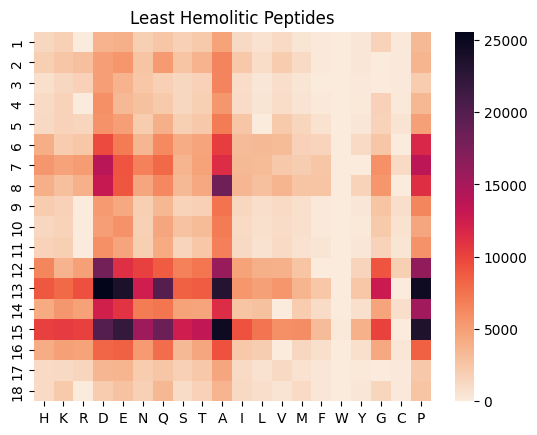

In [8]:
# prepare the matrix to plot the heatmap
least_hemo["difference_in_seq"] = [diff_func(x) for x in least_hemo["Sequence"]]
diff = least_hemo["difference_in_seq"].str.split("", n= -1, expand = True)
least_hemo =least_hemo.merge(diff, left_index=True, right_index=True)


# charged->polar->aliphatic->aromatic->other
aa_list = ['H', 'K', 'R', 'D', 'E', 'N', 'Q', 'S', 'T', 'A', 'I', 'L', 'V', 'M', 'F', 'W', 'Y','G', 'C', 'P']

#aa_list = ['H', 'K', 'R', 'D', 'E', 'A', 'I', 'L', 'V', 'M', 'F', 'W', 'Y', 'N', 'Q', 'S', 'T', 'G', 'C', 'P']
mtx = pd.DataFrame(0, index=aa_list, columns=np.arange(1, 19))

# fill the matix with the count of each amino acid in each position
for i in range(1, 19):
    pos_count = least_hemo[i].value_counts().to_dict()

    for k,v in pos_count.items():
        if k != '-':
            mtx.loc[k,i] = v

# plot the heatmap
plt.title("Least Hemolitic Peptides")
sns.heatmap(mtx.T, cmap="rocket_r")
#plt.savefig('results/changes_heatmap_predictions_least_hemolitic_v02.png' , dpi=1200)
plt.show()

# Most Selective

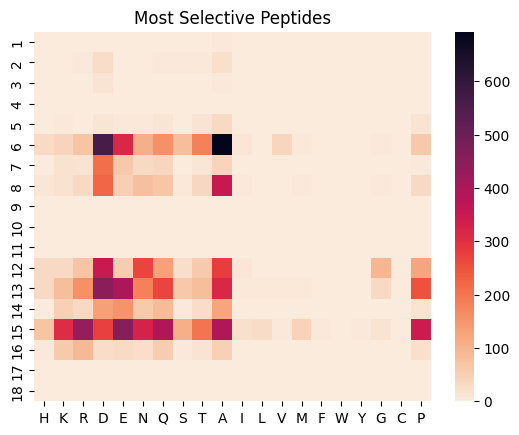

In [9]:
# prepare the matrix to plot the heatmap
most_sel["difference_in_seq"] = [diff_func(x) for x in most_sel["Sequence"]]
diff = most_sel["difference_in_seq"].str.split("", n= -1, expand = True)
most_sel= most_sel.merge(diff, left_index=True, right_index=True)

# charged->polar->aliphatic->aromatic->other
aa_list = ['H', 'K', 'R', 'D', 'E', 'N', 'Q', 'S', 'T', 'A', 'I', 'L', 'V', 'M', 'F', 'W', 'Y','G', 'C', 'P']

#aa_list = ['H', 'K', 'R', 'D', 'E', 'A', 'I', 'L', 'V', 'M', 'F', 'W', 'Y', 'N', 'Q', 'S', 'T', 'G', 'C', 'P']
mtx = pd.DataFrame(0, index=aa_list, columns=np.arange(1, 19))

# fill the matix with the count of each amino acid in each position
for i in range(1, 19):
    pos_count = most_sel[i].value_counts().to_dict()

    for k,v in pos_count.items():
        if k != '-':
            mtx.loc[k,i] = v


# plot the heatmap
plt.title("Most Selective Peptides")
sns.heatmap(mtx.T, cmap="rocket_r")
#plt.savefig('results/changes_heatmap_predictions_most_selective_v02.png' , dpi=1200)
plt.show()

## Bacterial Specific (MIC<=8, %hemo<=2, L10SS <1)

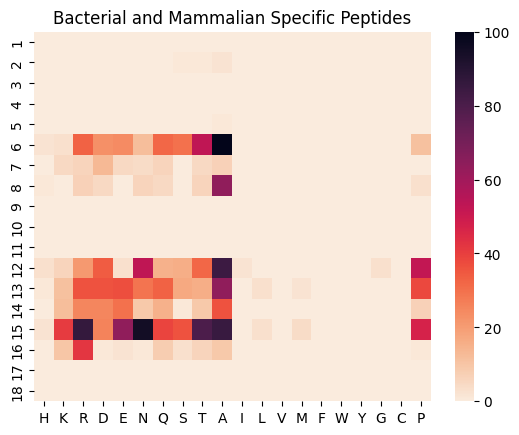

In [10]:
# prepare the matrix to plot the heatmap
bac["difference_in_seq"] = [diff_func(x) for x in bac["Sequence"]]
diff = bac["difference_in_seq"].str.split("", n= -1, expand = True)
bac = bac.merge(diff, left_index=True, right_index=True)


# charged->polar->aliphatic->aromatic->other
aa_list = ['H', 'K', 'R', 'D', 'E', 'N', 'Q', 'S', 'T', 'A', 'I', 'L', 'V', 'M', 'F', 'W', 'Y','G', 'C', 'P']

#aa_list = ['H', 'K', 'R', 'D', 'E', 'A', 'I', 'L', 'V', 'M', 'F', 'W', 'Y', 'N', 'Q', 'S', 'T', 'G', 'C', 'P']
mtx = pd.DataFrame(0, index=aa_list, columns=np.arange(1, 19))

# fill the matix with the count of each amino acid in each position
for i in range(1, 19):
    pos_count = bac[i].value_counts().to_dict()

    for k,v in pos_count.items():
        if k != '-':
            mtx.loc[k,i] = v

# plot the heatmap
plt.title("Bacterial and Mammalian Specific Peptides")
sns.heatmap(mtx.T, cmap="rocket_r")
#plt.savefig('results/changes_heatmap_predictions_bac_v02.png', dpi=1200)
plt.show()

## Mammalian specific (MIC>8, %hemo>50, L10SS >1). 

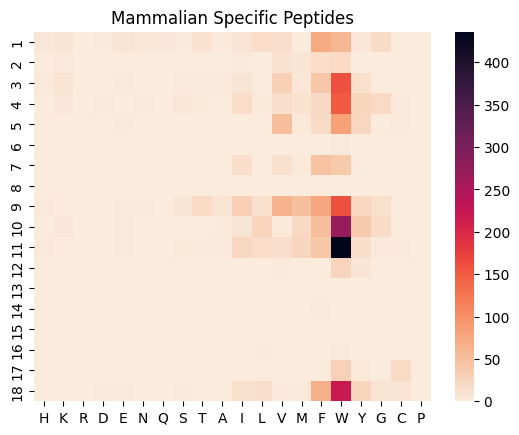

In [11]:
# prepare the matrix to plot the heatmap
mamm["difference_in_seq"] = [diff_func(x) for x in mamm["Sequence"]]
diff = mamm["difference_in_seq"].str.split("", n= -1, expand = True)
mamm =mamm.merge(diff, left_index=True, right_index=True)


# charged->polar->aliphatic->aromatic->other
aa_list = ['H', 'K', 'R', 'D', 'E', 'N', 'Q', 'S', 'T', 'A', 'I', 'L', 'V', 'M', 'F', 'W', 'Y','G', 'C', 'P']

#aa_list = ['H', 'K', 'R', 'D', 'E', 'A', 'I', 'L', 'V', 'M', 'F', 'W', 'Y', 'N', 'Q', 'S', 'T', 'G', 'C', 'P']
mtx = pd.DataFrame(0, index=aa_list, columns=np.arange(1, 19))

# fill the matix with the count of each amino acid in each position
for i in range(1, 19):
    pos_count = mamm[i].value_counts().to_dict()

    for k,v in pos_count.items():
        if k != '-':
            mtx.loc[k,i] = v

# plot the heatmap
plt.title("Mammalian Specific Peptides")
sns.heatmap(mtx.T, cmap="rocket_r")
#plt.savefig('results/changes_heatmap_predictions_mamm_v02.png' , dpi=1200)
plt.show()